In [31]:
import tsfresh as tsf
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import mord
import joblib
import dill
import imblearn

from importlib import reload
from scipy import signal, stats
from tqdm.auto import tqdm
from sklearn import preprocessing, neighbors, linear_model, ensemble, decomposition, compose
from sklearn import feature_selection, model_selection, metrics, dummy, pipeline, svm, neural_network
from dask_ml.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
from src import main, feature_model

In [32]:
features_df = pd.read_csv('extracted_features/tsfeatures.csv', index_col=0)

label_cols = ['on_off', 'dyskinesia', 'tremor', 'subject_id']
labels = pd.read_csv('/home/hy180/projects/beat_pd/data/cis-pd/data_labels/CIS-PD_Training_Data_IDs_Labels.csv', index_col=0)

# These features don't compute for a number of observations
drop_cols = ['rms__friedrich_coefficients__m_3__r_30__coeff_0',
       'rms__friedrich_coefficients__m_3__r_30__coeff_1',
       'rms__friedrich_coefficients__m_3__r_30__coeff_2',
       'rms__friedrich_coefficients__m_3__r_30__coeff_3',
       'rms__max_langevin_fixed_point__m_3__r_30']
df = labels[label_cols].merge(features_df.drop(columns=drop_cols), left_index=True, right_index=True)

# Looking at feature scales

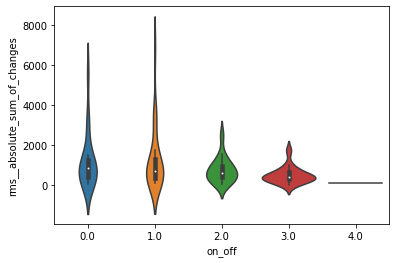

In [8]:
sns.violinplot(data=df[df.subject_id==1004], x='on_off', y='rms__absolute_sum_of_changes')

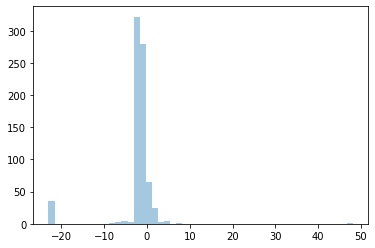

In [250]:
col_vars = scaler.fit_transform(features_df.values).var(axis=0)
x = col_vars[~np.isnan(col_vars)]
x[x==0] = 1e-10
sns.distplot(np.log(x), kde=False)

In [72]:
transformed = scaler.fit_transform(X)
{i: stats.describe(transformed[:, i]) for i in np.argsort(np.var(transformed, axis=0))[-2:]}

{718: DescribeResult(nobs=1188, minmax=(0.0, 37.62770355780406), mean=0.11768524241111035, variance=2.8449340574453883, skewness=18.703612872688158, kurtosis=370.2175597130023),
 693: DescribeResult(nobs=1188, minmax=(-31.570172034735972, 0.5976332943955401), mean=-0.10124334333043972, variance=3.377639813537305, skewness=-16.923487418963944, kurtosis=286.91941014911447)}

In [121]:
ran = X.max(axis=0) - X.min(axis=0)
iqr = pd.Series(stats.iqr(X, axis=0, rng=(5, 95)), index=ran.index)
rat = iqr/ran
(rat[rat > 0]).sort_values()
sns.distplot(rat, kde=False)

rms__augmented_dickey_fuller__autolag_"AIC"__attr_"pvalue"     3.311672e-12
rms__value_count__value_0                                      4.250884e-03
rms__ratio_value_number_to_time_series_length                  4.801011e-03
rms__percentage_of_reoccurring_datapoints_to_all_datapoints    4.826741e-03
rms__percentage_of_reoccurring_values_to_all_values            5.062206e-03
                                                                   ...     
rms__fft_coefficient__coeff_86__attr_"angle"                   9.166163e-01
rms__fft_coefficient__coeff_28__attr_"angle"                   9.205993e-01
rms__has_duplicate                                             1.000000e+00
rms__has_duplicate_min                                         1.000000e+00
rms__large_standard_deviation__r_0.05                          1.000000e+00
Length: 699, dtype: float64

/home/hy180/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


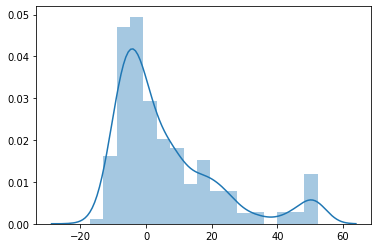

In [508]:
sns.distplot(np.log(scaler.fit_transform(X)[:, 63]))

In [73]:
X.iloc[:, 693]

cc7b822c-e310-46f0-a8ea-98c95fdb67a1    0.985844
5163afe8-a6b0-4ea4-b2ba-9b4501dd5912    0.986693
5cf68c8e-0b7a-4b73-ad4f-015c7a20fb5a    0.986080
fb188ae2-2173-4137-9236-19a137a402c2    0.996613
19a3e9ea-fce1-40b7-9457-2618970beb7b    0.997959
                                          ...   
b7c199d3-4b2d-4333-89d4-0079e20dada2    0.995882
e3a839dc-b254-49e5-9dbb-5e55654ccbb2    0.996418
c3084532-37e0-4a03-9369-9945c25fbe1b    0.998161
9861430e-70b9-4cea-a771-9b2dbf3574a9    0.992408
8c0b2fbd-f7ea-4753-8e31-ffd4ec00a027    0.998189
Name: rms__quantile__q_0.4, Length: 1188, dtype: float64

# Model

In [33]:
from dask_jobqueue import SLURMCluster
from distributed import Client, LocalCluster

In [35]:
try:
    cluster.close()
    client.close()
except NameError:
    pass
finally:
    cluster = SLURMCluster(queue='short', cores=2, memory='2gb', walltime='1:00:00', death_timeout=60)
    client = Client(cluster)
    cluster.adapt(minimum=1, maximum=30)

In [8]:
# Local cluster for debugging
try:
    local_cluster.close()
    local_client.close()
except NameError:
    pass
finally:
    local_cluster = LocalCluster(n_workers=4, threads_per_worker=1, dashboard_address='0.0.0.0:8786')
    local_client = Client(local_cluster)
    local_cluster.adapt(minimum=0, maximum=4)

In [37]:
scaler = preprocessing.RobustScaler(quantile_range=(1, 99))
scaler_pg = {'scaler__quantile_range': [(.1, 99.9), (.5, 99.5), (1, 99), (5, 95), (10, 90)],}
# scaler = preprocessing.MinMaxScaler()

# Keep features w/ variance in top 95%ile 
var = lambda X, y: np.var(X, axis=0)
f_select = feature_selection.SelectPercentile(var, percentile=95)
# f_select_pg = {'f_select__percentile': [95, 80, 50, 25, 10],}
f_select_pg = {'f_select__percentile': stats.uniform(0, 100)}
# f_select = feature_selection.SelectKBest(feature_selection.mutual_info_regression, k=30)

# model = linear_model.Ridge()
# model_pg = {'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = svm.SVR()
# model_pg = {'model__regressor__kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'model__regressor__C': stats.chi2(df=2)}
# model = linear_model.ElasticNet()
# model_pg = {'model__regressor__l1_ratio': stats.uniform(0, 1), 'model__regressor__alpha': stats.chi2(df=2), }
# model_pg = {'model__regressor__l1_ratio': [0.01, 0.1, 0.5, 0.8, 0.99], 'model__regressor__alpha': [0.1, 0.5, 1, 2, 5],}
# model = mord.OrdinalRidge()
# model_pg = {'model__regressor__alpha': stats.chi2(df=2), }
model = ensemble.RandomForestRegressor()
model_pg = {'model__regressor__n_estimators': stats.randint(3, 100), 'model__regressor__max_depth': stats.randint(2, 20), 'model__regressor__max_features': [.05, .25, 'auto', 'sqrt', 'log2']}
# model = neural_network.MLPRegressor(learning_rate='adaptive')
# model_pg = {'model__regressor__hidden_layer_sizes': [(100), (50, 50)]}

clip_out = preprocessing.FunctionTransformer(np.clip, kw_args={'a_min': 0, 'a_max': 4})
clipped_model = compose.TransformedTargetRegressor(regressor=model, inverse_func=clip_out.transform)

pipe = pipeline.Pipeline([
    ('scaler', scaler), 
    ('f_select', f_select), 
    ('model', clipped_model),
], verbose=1)

param_grid = {
    **scaler_pg,
    **f_select_pg,
    **model_pg,
}

metric = metrics.make_scorer(metrics.mean_squared_error, greater_is_better=False)

cv = model_selection.StratifiedKFold(shuffle=True)
search = RandomizedSearchCV(pipe, param_grid, n_iter=300, scoring=metric, cv=cv, scheduler=client)

In [38]:
label = 'tremor'
features = df[df.index.isin(df.dropna(subset=[label]).index)].drop(columns=[*label_cols])

y = df.loc[features.index, label].astype('int')
X = features

In [39]:
# with joblib.parallel_backend('dask', client=client, scatter=[X, y]):
cv_fit = search.fit(X, y)
cv_results = pd.DataFrame(cv_fit.cv_results_)

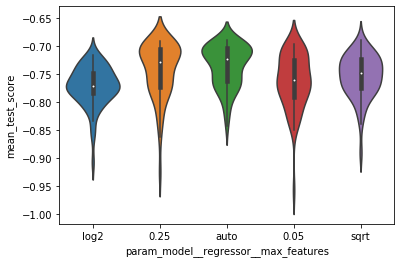

In [44]:
sns.violinplot(data=cv_results, x='param_model__regressor__max_features', y='mean_test_score')

In [40]:
cv_results.sort_values(by='rank_test_score')

,params,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,param_f_select__percentile,param_model__regressor__max_depth,param_model__regressor__max_features,param_model__regressor__n_estimators,param_scaler__quantile_range
229,"{'f_select__percentile': 82.59640373552045, 'm...",17.068669,0.453412,0.019460,0.008679,-0.666553,-0.747802,-0.666567,-0.669312,-0.693581,-0.688788,0.031241,1,82.5964,14,auto,51,"(0.1, 99.9)"
149,"{'f_select__percentile': 47.73931129854891, 'm...",1.306923,0.150636,0.014560,0.004104,-0.673588,-0.713219,-0.667518,-0.673991,-0.716825,-0.689034,0.021377,2,47.7393,12,sqrt,68,"(0.1, 99.9)"
148,"{'f_select__percentile': 77.48348571512687, 'm...",6.765362,0.660435,0.023515,0.007330,-0.674330,-0.727911,-0.678666,-0.679874,-0.688462,-0.689864,0.019592,3,77.4835,19,0.25,71,"(0.5, 99.5)"
28,"{'f_select__percentile': 83.29919352048799, 'm...",2.975589,0.527827,0.016590,0.007392,-0.673640,-0.717876,-0.659479,-0.672881,-0.727027,-0.690188,0.026977,4,83.2992,7,0.25,39,"(10, 90)"
29,"{'f_select__percentile': 61.12794120106829, 'm...",4.468936,0.222494,0.015096,0.001623,-0.681095,-0.751628,-0.650492,-0.665442,-0.703195,-0.690406,0.035269,5,61.1279,12,0.25,64,"(0.1, 99.9)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,"{'f_select__percentile': 0.8848279997304642, '...",0.564913,0.144397,0.046076,0.051814,-0.855495,-0.853825,-0.879778,-0.869383,-0.853603,-0.862406,0.010479,296,0.884828,10,0.25,96,"(10, 90)"
39,"{'f_select__percentile': 98.41028801266182, 'm...",0.531827,0.018127,0.008747,0.002471,-0.879320,-0.874314,-0.919555,-0.822765,-0.954593,-0.890091,0.044529,297,98.4103,9,sqrt,3,"(1, 99)"
58,"{'f_select__percentile': 5.916401514181102, 'm...",0.531300,0.014911,0.008507,0.003457,-0.899877,-0.920727,-0.880752,-0.914484,-0.920466,-0.907265,0.015260,298,5.9164,16,log2,9,"(0.1, 99.9)"
84,"{'f_select__percentile': 33.331366988506915, '...",0.638625,0.026412,0.010200,0.006250,-0.922707,-0.928101,-0.912109,-0.952540,-0.908070,-0.924706,0.015647,299,33.3314,11,0.25,4,"(1, 99)"


In [102]:
winner = cv_fit.best_estimator_
winner_fp = f'models/paramsweep_winners/{type(model).__name__}_{label}.model'
with open(winner_fp, 'wb') as f:
    dill.dump(winner, f)

# Baseline for reference

In [46]:
# label = 'dyskinesia'
features = df[df.index.isin(df.dropna(subset=[label]).index)].drop(columns=[*label_cols])

y = df.loc[features.index, label].astype('int')
X = features

Text(0.5, 1.0, 'mse of null model: -0.955526')

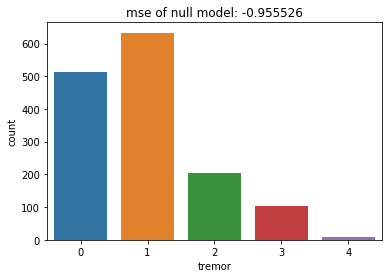

In [47]:
baseline_model = dummy.DummyRegressor(strategy='mean')
baseline_cv = model_selection.cross_validate(baseline_model, X, y, scoring=metric)
baseline_scores = baseline_cv['test_score']
ax = sns.countplot(y)
ax.set_title('mse of null model: %f' % baseline_scores.mean())

In [116]:
with open(f'models/paramsweep_winners/RandomForestRegressor_{label}.model', 'rb') as f:
    winner = dill.load(f)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing f_select, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing model, total=   5.0s


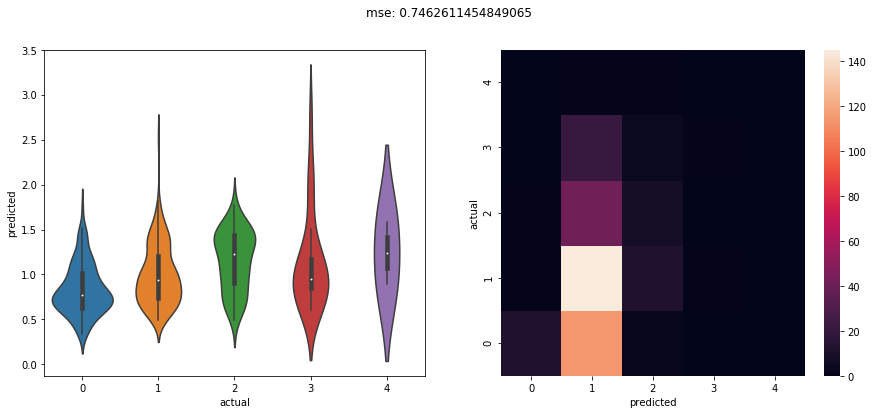

In [48]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.25, stratify=y)
# x_train, y_train = smote.fit_resample(x_train, y_train)

with joblib.parallel_backend('loky'):
    winner.fit(x_train, y_train)
    pred = winner.predict(x_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.violinplot(data=pd.DataFrame({'actual': y_test, 'predicted': pred}), x='actual', y='predicted', ax=ax1)

# confusion matrix
label_vals = np.sort(y_test.unique())
cm = metrics.confusion_matrix(y_test, np.round(pred), labels=label_vals)
sns.heatmap(cm, xticklabels=label_vals, yticklabels=label_vals, ax=ax2)
ax2.set_xlabel('predicted')
ax2.set_ylabel('actual')
ax2.invert_yaxis()

mse = metrics.mean_squared_error(y_test, pred)
_ = fig.suptitle(f'mse: {mse}')

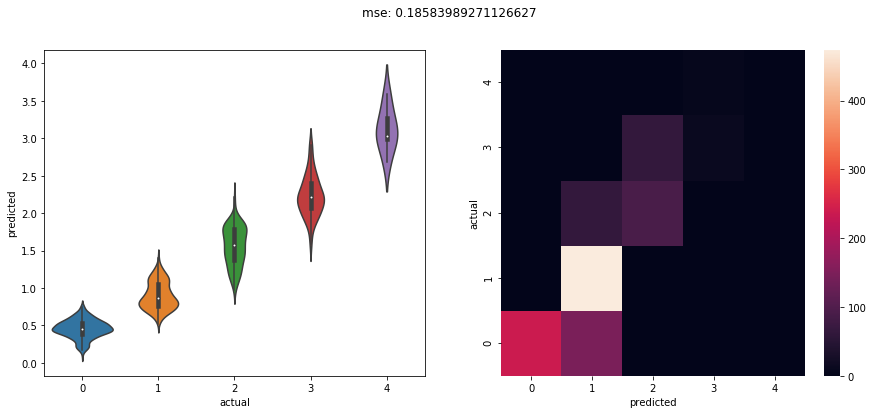

In [49]:
# training set recall
x_test, y_test = x_train, y_train
pred = winner.predict(x_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.violinplot(data=pd.DataFrame({'actual': y_test, 'predicted': pred}), x='actual', y='predicted', ax=ax1)

# confusion matrix
label_vals = np.sort(y_test.unique())
cm = metrics.confusion_matrix(y_test, np.round(pred), labels=label_vals)
sns.heatmap(cm, xticklabels=label_vals, yticklabels=label_vals, ax=ax2)
ax2.set_xlabel('predicted')
ax2.set_ylabel('actual')
ax2.invert_yaxis()

mse = metrics.mean_squared_error(y_test, pred)
_ = fig.suptitle(f'mse: {mse}')

# Predictions on test set

In [529]:
# TODO: only predict required measurements for each label
test_index = pd.read_csv(f'test_predictions/sub_template_{label}.csv', index_col=0).index
test_features_df = pd.concat([
    pd.read_csv('tsfeatures_cis_test.csv', index_col=0), 
    pd.read_csv('tsfeatures_real_test.csv', index_col=0)
]).drop(columns=drop_cols).reindex(test_index)

In [530]:
test_features_df

,rms__abs_energy,rms__absolute_sum_of_changes,"rms__agg_autocorrelation__f_agg_""mean""__maxlag_40","rms__agg_autocorrelation__f_agg_""median""__maxlag_40","rms__agg_autocorrelation__f_agg_""var""__maxlag_40","rms__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","rms__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","rms__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","rms__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","rms__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,rms__symmetry_looking__r_0.9,rms__symmetry_looking__r_0.9500000000000001,rms__time_reversal_asymmetry_statistic__lag_1,rms__time_reversal_asymmetry_statistic__lag_2,rms__time_reversal_asymmetry_statistic__lag_3,rms__value_count__value_-1,rms__value_count__value_0,rms__value_count__value_1,rms__variance,rms__variance_larger_than_standard_deviation
measurement_id,,,,,,,,,,,,,,,,,,,,,
0e80673b-8c90-474f-8388-00fdf25795e4,4.608378e+03,64.202341,0.025610,-0.003944,0.008261,1.000375,0.184082,0.000096,0.000024,1.007698,...,1.0,1.0,-0.000128,-0.000010,-0.000004,0.0,6.0,0.0,0.002315,0.0
a7b61d40-9f26-4878-a2d7-bd766b8ae6f5,1.287790e+04,1251.071931,0.022370,0.018705,0.003880,1.196276,0.040485,0.000030,0.000021,1.333129,...,1.0,1.0,-0.001075,-0.000637,0.000291,0.0,26.0,0.0,0.029319,0.0
fc851afd-133c-4e8f-8deb-0079cc442358,1.231101e+04,652.260342,0.040507,0.035125,0.002053,1.104594,-0.015321,-0.000005,0.000010,1.247376,...,1.0,1.0,-0.000179,-0.000201,-0.000087,0.0,14.0,0.0,0.006764,0.0
90c2c320-1007-47b4-9f8e-cdd37067dfb2,1.178726e+04,183.810317,0.120155,0.093211,0.013164,1.019789,-0.057811,-0.000009,0.000004,1.051978,...,1.0,1.0,0.000029,0.000035,0.000016,0.0,27.0,0.0,0.003321,0.0
379fd23b-e38f-4214-8a70-7a829004359f,1.215183e+04,124.875463,0.051620,0.018297,0.013081,0.996694,0.306034,0.000046,0.000004,0.979234,...,1.0,1.0,-0.000002,-0.000008,-0.000015,0.0,9.0,0.0,0.001774,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220207f0-5e58-4523-9004-8cb9e78c826e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9cb8f12b-572e-41dd-870f-219e9bc59fb3,1.161166e+06,1592.121847,0.008002,0.004404,0.004508,10.218340,-0.177918,-0.000293,0.000047,10.528928,...,1.0,1.0,-0.006612,-0.008155,0.003440,0.0,31.0,0.0,0.346320,0.0
1095910c-dd62-4d6d-b57c-00668181ff17,1.159483e+06,263.683339,0.070541,0.006431,0.022662,9.825180,0.235636,0.000053,0.000006,9.845765,...,1.0,1.0,0.001192,0.002335,0.004290,0.0,14.0,0.0,0.114864,0.0


In [452]:
test_predictions = winner.predict(test_features_df)
test_predictions_df = pd.DataFrame({'measurement_id': test_features_df.index, 'prediction': test_predictions})

In [453]:
test_predictions_df.to_csv(f'test_predictions/test_predictions_{label}.csv', index=False)

# Dimensionality Reduction

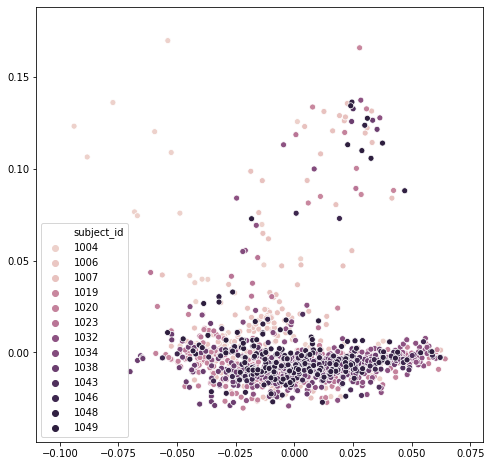

In [164]:
label = 'subject_id'

X = f_select.fit_transform(scaler.fit_transform(features), y=y)
pca = decomposition.FastICA(n_components=2)
proj = pca.fit_transform(X)
fig = plt.figure(figsize=(8, 8))
_ = sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=df.loc[features.index, label], legend='full')